# <center/> CS146: Assignment II
# <center/> Taha Bouhoun

In [195]:
import numpy as np
from math import*
import pandas as pd
import scipy as sp
import random as rn
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

# Call center data modeling
Complete the call center data modeling assignment we start in the Pre-class work and Activity 2 breakouts of Session 2.2. You may re-use and build on all code or any other work from the class session.
In class, we completed the Bayesian data modeling problem for 1 hour of the day. In this assignment, you need to do the same analysis for all 24 hours of the day.

- Compute a 98% posterior confidence interval over the number of calls per minute (the call rate λ ) for each hour of the day — so you will have 24 confidence intervals. Also, compute the posterior mean of λ for each hour of the day.
- Present your results graphically using Matplotlib. Make a plot that looks like the one below. Each dot is at the posterior mean and each line shows a 98% confidence interval for a λ. You can use the errorbar() function in the plotting library to do this.

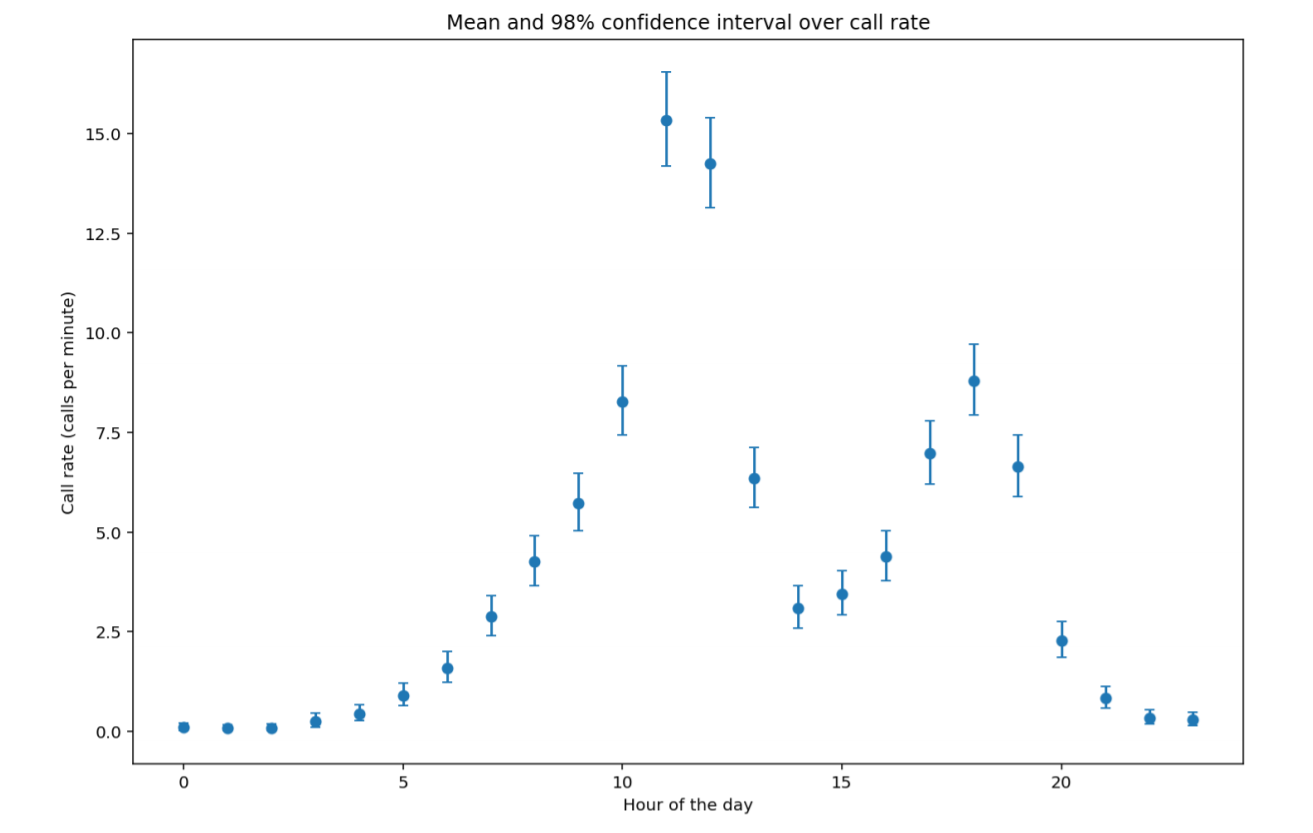

## I. Processing the data

Size of data set: 5856 

00:00-01:00 - 5 calls
01:00-02:00 - 4 calls
02:00-03:00 - 6 calls
03:00-04:00 - 8 calls
04:00-05:00 - 26 calls
05:00-06:00 - 53 calls
06:00-07:00 - 93 calls
07:00-08:00 - 173 calls
08:00-09:00 - 254 calls
09:00-10:00 - 345 calls
10:00-11:00 - 496 calls
11:00-12:00 - 924 calls
12:00-13:00 - 858 calls
13:00-14:00 - 382 calls
14:00-15:00 - 185 calls
15:00-16:00 - 207 calls
16:00-17:00 - 263 calls
17:00-18:00 - 419 calls
18:00-19:00 - 531 calls
19:00-20:00 - 400 calls
20:00-21:00 - 137 calls
21:00-22:00 - 51 calls
22:00-23:00 - 20 calls
23:00-24:00 - 16 calls


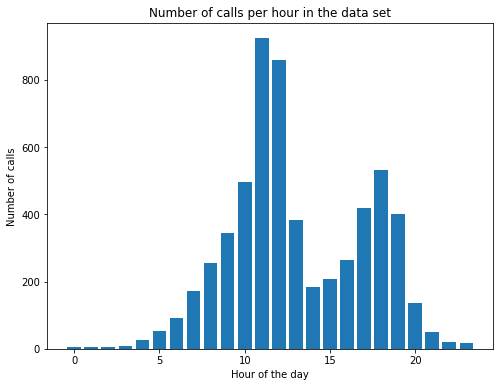

In [243]:
# Code from Call Center Breakout [Session 2.2]

# Loading the call center data
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set. [we can check the library that does that better]
print('Size of data set:', len(waiting_times_day),'\n')

# -------------------------------------------------------- #
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# reconsider using this bit of code: 
for hour, waiting_times_hour in enumerate(waiting_times_per_hour):
    print('%02i:00-%02i:00 - %i calls' % (hour, hour + 1, len(waiting_times_hour)))
# -------------------------------------------------------- #

# Plot the number of calls per hour using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.xlabel('Hour of the day')
plt.ylabel('Number of calls')
plt.title('Number of calls per hour in the data set')
plt.show()

In [238]:
# consider another dataframe to work with
data = pd.DataFrame(waiting_times_per_hour)
len(data)
data = data.T

## II. Distribution of calls for one hour

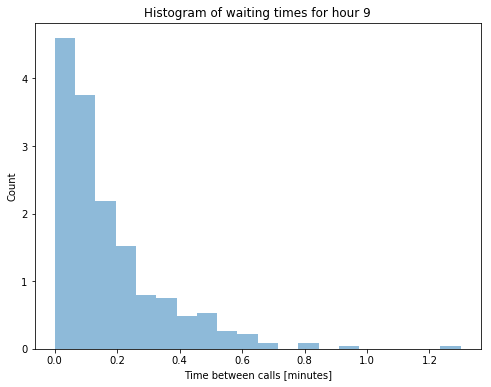

In [244]:
# Plot histogram of waiting times for one hour

hour_index = 9
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 8))
plt.hist(waiting_times_hour, bins=20, alpha=0.5, density= True)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')
plt.show()

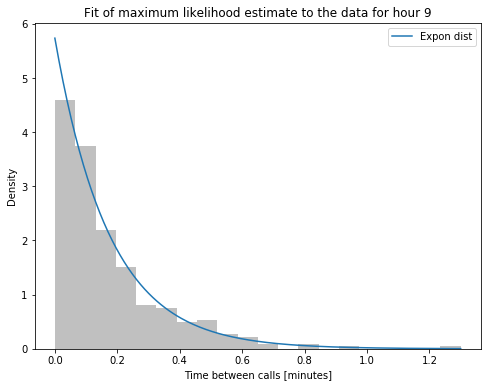

In [245]:
# Exponential distribution with maximum likelihood fit to the data

lambda_ = 1 / np.mean(waiting_times_hour)
dist = sts.expon(scale=1/lambda_)

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
x = np.linspace(0, max(waiting_times_hour), 200)
y = dist.pdf(x)

plt.plot(x, y, label ='Expon dist')
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
plt.legend(loc=1)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000226C28A66A0>,
      dtype=object)

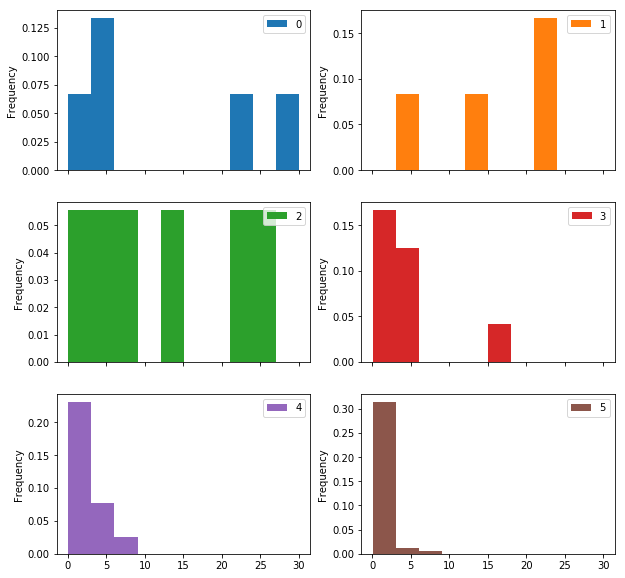

In [78]:
new_data = data[list(range(6))]
new_data.plot.hist(subplots=True, layout=(3,2), figsize=(10, 10), density = True)

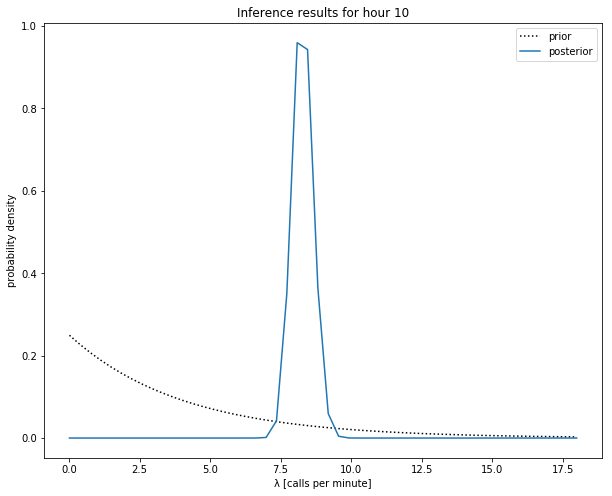

In [79]:
"""
THE LIKELIHOOD FUNCTION
This function takes 2 inputs, namely the parameter (λ) value at which to
compute the likelihood and a value from the data set. You need to evaluate
the exponential distribution of the datum given the parameter value.
"""

def likelihood(lambda_, datum):
    # return sts.expon.pdf(datum, scale=1/lambda_)
    return sts.expon(scale=1/lambda_).pdf(datum)

"""
THE PRIOR DISTRIBUTION
This function takes 1 input, namely the parameter value (λ) at which to
compute the prior probability density. You need to evaluate the distribution
Gamma(λ | α, β).
"""

def prior(lambda_):
    alpha = 1
    beta = 0.25
    return sts.gamma(a=alpha, scale=1/beta).pdf(lambda_)

"""
THE POSTERIOR DISTRIBUTION

The function below is provided to help make computing the posterior easier. It
follows the same pattern as in the previous class, where we multiple the prior
and the likelihood evaluated at various values of the parameter (λ).

You will see the function uses the logarithms of various distributions. This
is for numerical reasons. When you multiply lots of likelihood values, the
result can become very large or very small, causing numerical overflow or
underflow in Python. Taking logarithms avoids this problem.
"""

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

lambdas = np.linspace(0.01, 18)
posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.figure(figsize=(10, 8))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, label='posterior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour {hour_index}')
plt.legend()
plt.show()

In [80]:
def compute_percentile(parameter_values, distribution_values, percentile):
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

# YOU HAVE TO USE THE FUNCTION ABOVE TO COMPUTE THE CONFIDENCE INTERVAL
print("The upper bound: ", compute_percentile(lambdas, posterior, 0.99))
print("The lower bound: ", compute_percentile(lambdas, posterior, 0.01))

The upper bound:  9.188571428571427
The lower bound:  7.352857142857141


- Write a paragraph (100–200 words) to accompany your plot and present your findings to the client. Carefully summarize how many calls you expect during different parts of the day, and how much uncertainty there is in your estimates. Remember that the client is not an expert in statistics, so make it easy for them to understand. You may also make additional plots to help communicate your results

### Stretch goal (optional)
Explain how the compute_posterior function (reproduced below) from Lesson 2.2 works. We discussed the function briefly in class. For a complete answer you need to address all the points below. You can also add any other information you think is relevant to the techniques used in the function.

1. The purpose of the function is to multiply the prior and likelihood passed as input arguments and to return the posterior as output. Explain how the function achieves this purpose using logarithms.
2. What is the purpose of np.sum() in line 4?
3. Explain why the maximum of the unnormalized log posterior is subtracted in line 7.
4. Why do we still have to divided by the area in line 10 even after having subtracted the maximum of the unnormalized log posterior in line 7?
5. Create an example where not taking logarithms would cause a problem. Create a prior, likelihood, and data set that fails to produce the correct posterior when we don’t take logs.

Show all your code and visualize your results on one or more plots

### More practice exercises (optional)
Below are additional practice exercises for you to attempt. These are optional and you can choose to do as many or as few as you want. These exercises will not be graded.
If you get stuck on any of them, contact your instructor with specific questions via email and during office hours. Just saying “I’m stuck” is not enough — explain what you tried and where you got stuck so your instructor can understand your thinking and where you might have missed something or made a mistake.

1. Answer the following questions using Python.
    - Generate 1000 samples from a normal distribution with mean 100 and standard deviation 10. How many of the numbers are at least 2 standard deviations away from the mean? How many to you expect to be at least 2 standard deviations away from the mean?
    - Toss a fair coin 50 times. How many heads do you have? How many heads to you expect to have?
    - Roll a 6-sided die 1000 times. How many 6s did you get? How many 6s do you expect to get?
    - How much area (probability) is to the right of 1.5 for a normal distribution with mean 0 and standard deviation 2?

In [197]:
# Sampling form a normal distribution:
# needs to be revised because the numbers should be different every time

mu, sd = 100, 10
sample = np.random.normal(mu, sd, 1000)
print(len([x for x in sample if (abs(x-mu) > 2*sd)]))

49


In [198]:
# Coin toss:
# We assume that head is represented by 1 and tail is represented by 0

print("Number of heads:", sum(rn.choice([0, 1]) for _ in range(50)))

Number of heads: 35


In [199]:
# 6-sided die:
# We assume that 6 is represented by 1 and the other numbers by 0

print("Number of 6s:", sum(rn.choice([0,0,0,0,0,1]) for _ in range(1000)))

Number of 6s: 156


2. Let y be the number of 6s in 1000 rolls of a fair die.
    - Draw a sketch of the approximate distribution of y, based on the normal approximation.
    - Using the normal distribution function in SciPy, give approximate 5%, 25%, 50%, 75%, and 95% points for the distribution of y.

mean:  166.66666666666666 
 SD :  11.785113019775793


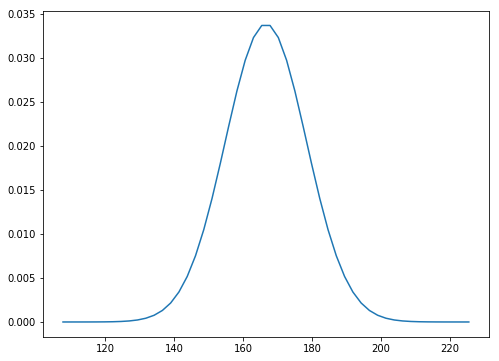

In [226]:
# Parameters of the normal distribution:
# mean = n * P 
# standard deviation = sqrt[ n * P * ( 1 - P ) ]

mu = 1000 * (1/6)
sd = sqrt(1000 * (1/6) * (1 - (1/6)))
print('mean: ', mu,'\n SD : ', sd)

x = np.linspace(mu-5*sd, mu+5*sd)
plt.figure(figsize=(8, 6))
plt.plot(x, sts.norm.pdf(x, mu, sd))

In [234]:
approx = [0.05, 0.25, 0.50, 0.75, 0.95]
n_approx = list(sts.norm.ppf(approx, mu, sd))
for _ in range (len(approx)):
    print(approx[_], 'percentile: ', n_approx[_])

0.05 percentile:  147.28188077205542
0.25 percentile:  158.71772872992548
0.5 percentile:  166.66666666666666
0.75 percentile:  174.61560460340783
0.95 percentile:  186.0514525612779


3. A random sample of n students is drawn from a large population, and their weights are measured. The average weight of the sampled students is ˉy = 75 kg. Assume the weights in the population are normally distributed with unknown mean μ and known standard deviation 10 kg. Suppose your prior distribution for μ is normal with mean 180 and standard deviation 40.
    - Give your posterior distribution for μ. (Your answer will be a function of n. )
    - A new student is sampled at random from the same population and has a weight of y′ pounds. Give a posterior predictive distribution for y′. (Your answer will still be a function of n. )
    - For n = 10, give a 95% posterior interval for theta and a 95% posterior predictive interval for y′.
    - Do the same for n = 100.

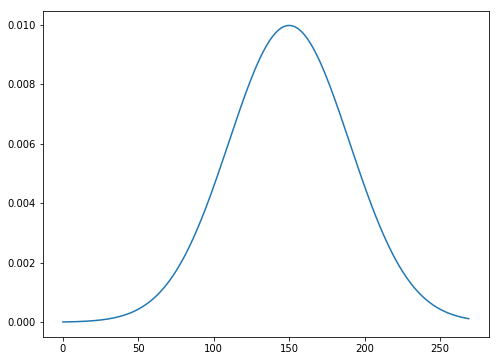

In [235]:
# Prior distribution:

x = np.arange(30, 300)
prior = sts.norm.pdf(x, 180, 40)

plt.figure(figsize=(8, 6))
plt.plot(prior)

4. Perfectly and partially observed data in the exponential model.
    - Suppose y | λ is exponentially distributed with rate λ, and the prior distribution of λ is Gamma (α, β). Suppose we observe that y ≥ 100, but do not observe the exact value of y. What is the posterior distribution, p(λ | y ≥ 100), as a function of α and β ? Write down the posterior mean and variance of λ.
    - In the above problem, suppose that we are now told that y is exactly 100. Now, what are the posterior mean and variance of λ ?
    - Explain why the posterior variance of λ is higher in part (b) even though more specific information has been observed.